In [1]:
!pip install catboost optuna ipywidgets shap pandas-profiling==2.8.0 -qqq
!gdown --id 1-Delsju0GjdVxWtfFDjriR7m4SBUfmqv
!gdown --id 163V0a0j6TsjJ7HHjKLMDF3Z2abpyEdbq
!gdown --id 14QZb0o9nArgqp5j2GFGxwxUglSm2t4_6

     |████████████████████████████████| 67.4 MB 29 kB/s 
     |████████████████████████████████| 302 kB 42.8 MB/s 
     |████████████████████████████████| 356 kB 50.1 MB/s 
     |████████████████████████████████| 259 kB 44.6 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 675 kB 40.4 MB/s 
     |████████████████████████████████| 3.1 MB 34.9 MB/s 
     |████████████████████████████████| 812 kB 45.5 MB/s 
     |████████████████████████████████| 28.5 MB 47 kB/s 
     |████████████████████████████████| 208 kB 34.6 MB/s 
     |████████████████████████████████| 80 kB 8.6 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 111 kB 48.3 MB/s 
     |████████████████████████████████| 144 kB 49.0 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [32]:
import numpy as np
import catboost
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import shap
%matplotlib inline
plt.style.use('seaborn-notebook')
sns.set(style="darkgrid")
SEED = 42
device = "GPU"

In [3]:
train = pd.read_csv('train_data.csv')
label = pd.read_csv('train_results.csv')
test = pd.read_csv('test_data.csv')
train = pd.merge(train, label, on='id')

In [4]:
# Remove highly related coulmns, unique coulmns, and  columns with many zero values
def remove_cols(X):
    cols = ['id','amount_tsh',  'num_private', 'region', 
          'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group',
         'extraction_type_group','recorded_by','date_recorded']
    for i in cols:
        del X[i]
    return X
train = remove_cols(train)
test_id = test['id']
test = remove_cols(test)

In [5]:
train['scheme_management'].fillna(train['scheme_management'].mode()[0], inplace=True)
test['scheme_management'].fillna(test['scheme_management'].mode()[0], inplace=True)

In [6]:
def construction_impute(X, mean_val):
    X['construction_year'].replace(0, mean_val, inplace=True)
    return X

mean_cons = train[train['construction_year'] != 0]['construction_year'].mean()

train = construction_impute(train,mean_cons)
test = construction_impute(test,mean_cons)

In [7]:
def locs(X_train, X_test):
    trans = ['longitude', 'latitude', 'gps_height', 'population']
    for i in [X_train, X_test]:
        i.loc[i.longitude == 0, 'latitude'] = 0
    for z in trans:
        for i in [X_train, X_test]:
            i[z].replace(0., np.NaN, inplace = True)
            i[z].replace(1., np.NaN, inplace = True)
        
        for j in ['subvillage', 'district_code', 'basin']:
        
            X_train['mean'] = X_train.groupby([j])[z].transform('mean')
            X_train[z] = X_train[z].fillna(X_train['mean'])
            o = X_train.groupby([j])[z].mean()
            fill = pd.merge(X_test, pd.DataFrame(o), left_on=[j], right_index=True, how='left').iloc[:,-1]
            X_test[z] = X_test[z].fillna(fill)
        
        X_train[z] = X_train[z].fillna(X_train[z].mean())
        X_test[z] = X_test[z].fillna(X_train[z].mean())
        del X_train['mean']
    return X_train, X_test


train,test = locs(train,test)

In [8]:
def transform_to_log_scale(X,column_name):
    X[column_name] = np.log(X[column_name])
    return X

train = transform_to_log_scale(train,"population")
test = transform_to_log_scale(test,"population")

In [9]:
def bools(X_train, X_test):
    z = ['public_meeting', 'permit']
    for i in z:
        X_train[i].fillna(False, inplace = True)
        X_train[i] = X_train[i].apply(lambda x: float(x))
        X_test[i].fillna(False, inplace = True)
        X_test[i] = X_test[i].apply(lambda x: float(x))
    return X_train, X_test

train,test = bools(train,test)

In [10]:
cols = train.columns
num_cols = train.select_dtypes('number').columns
cat_cols = list(set(cols) - set(num_cols))
assert len(num_cols)+len(cat_cols) == len(list(train.columns))

In [11]:
def std_scale(X):
    for col in num_cols:
        scale = StandardScaler().fit(X[[col]])
        X[col] = scale.transform(X[[col]])
    return X
train = std_scale(train)
test = std_scale(test)

In [12]:
target = train['status_group']
train.drop(['status_group'], axis=1, inplace=True)

In [13]:
#Categorical variables encoding
#Not included for catboost

cols = train.columns
num_cols = train.select_dtypes('number').columns
cat_cols = list(set(cols) - set(num_cols))

def dummies(X_train, X_test):
    X_train = X_train.copy()
    X_test = X_test.copy()
    encoder = preprocessing.LabelEncoder()
    X_train[cat_cols] = X_train[cat_cols].astype(str).apply(encoder.fit_transform)
    X_test[cat_cols] = X_test[cat_cols].astype(str).apply(encoder.fit_transform)
    return X_train,X_test

train_,test_ = dummies(train,test)
target_ = target.map({"non functional":0,"functional needs repair":1,"functional":2})

In [14]:
# profile = ProfileReport(train, title="Pandas Profiling Report", html={'style':{'full_width':True}});
# profile.to_notebook_iframe();

# Random Forest

In [15]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(train_, target_, test_size=0.3, random_state=SEED)

In [30]:
model = RandomForestClassifier(n_estimators=200, random_state=42, verbose=1)
model.fit(X_train_, y_train_)
predictions_ = model.predict(test_) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


In [31]:
submission_df = pd.DataFrame(columns=['id','status_group'])
submission_df['id'] = test_id
submission_df['status_group'] = predictions_
submission_df['status_group'] = submission_df['status_group'].map({0:"non functional",1:"functional needs repair",2:"functional"})
submission_df.to_csv("submission.csv",index=False,header=True)

#SVM

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_, y_train_)

In [34]:
pred = clf.predict(test_)

In [36]:
submission_df = pd.DataFrame(columns=['id','status_group'])
submission_df['id'] = test_id
submission_df['status_group'] = pred
submission_df['status_group'] = submission_df['status_group'].map({0:"non functional",1:"functional needs repair",2:"functional"})
submission_df.to_csv("submission.csv",index=False,header=True)

#CatBoost

In [17]:
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
for dataset in (train, test, ):
        for name in cat_cols:
            dataset[name].fillna('nan', inplace=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split( train, target, test_size=0.3, random_state=42)

In [19]:
nulls = train.isnull().sum()
nulls[nulls!=0]

Series([], dtype: int64)

In [20]:
train_pool = catboost.Pool(X_train, y_train,cat_features=cat_cols)
eval_pool = catboost.Pool(X_test, y_test,cat_features=cat_cols)
test_pool = catboost.Pool(test, cat_features=cat_cols)
final_train_pool = catboost.Pool(data=train, label=target,cat_features=cat_cols)

In [21]:
model = CatBoostClassifier(task_type=device)

In [ ]:
model.fit(final_train_pool,plot=True,early_stopping_rounds=10)

In [23]:
y_pred = model.predict(test_pool)

In [24]:
submission_df = pd.DataFrame(columns=['id','status_group'])
submission_df['id'] = test_id
submission_df['status_group'] = y_pred
submission_df.to_csv("submission.csv",index=False,header=True)

# Feature Importance

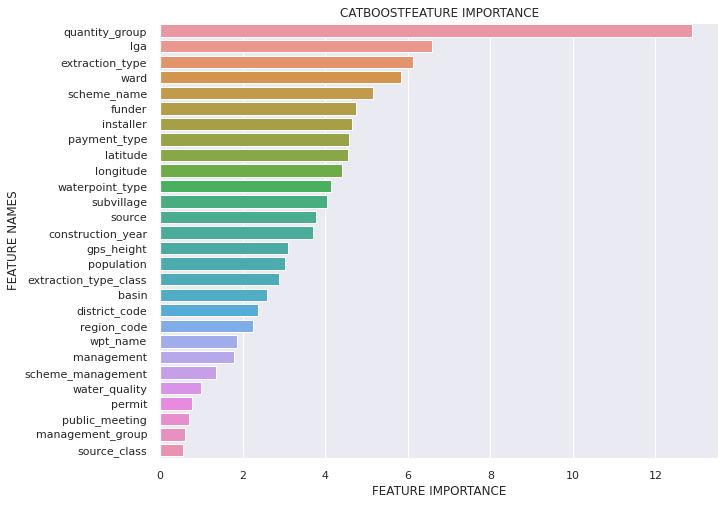

In [25]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot the catboost result
plot_feature_importance(model.get_feature_importance(),train.columns,'CATBOOST')

In [26]:
shap.initjs()
explainer = shap.TreeExplainer(model)

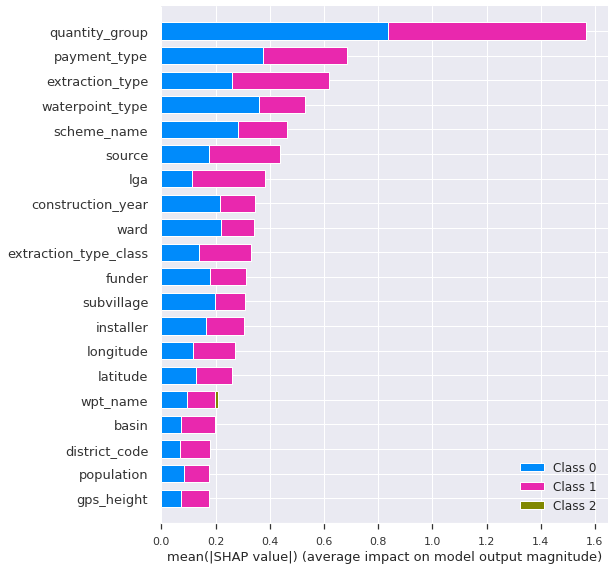

In [27]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)